In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!pwd

/content


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [ ]:
np.random.seed(42)
skin_df = pd.read_csv('/content/gdrive/MyDrive/IIITA Documents/M.Tech._2nd_SEM_Project_(mit2020068)/Datasets/HAM10000_metadata.csv')

SIZE=32

In [ ]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx  ...     sex     localization label
1617  HAM_0007180  ISIC_0033272  mel  ...    male             face     4
8128  HAM_0007195  ISIC_0031923   nv  ...  female  lower extremity     5
2168  HAM_0001835  ISIC_0026652  mel  ...    male             back     4
1090  HAM_0000465  ISIC_0030583  bkl  ...  female            trunk     2
7754  HAM_0001720  ISIC_0034010   nv  ...    male          abdomen     5
8071  HAM_0006333  ISIC_0024424   nv  ...    male            trunk     5
7423  HAM_0004548  ISIC_0032832   nv  ...  female  upper extremity     5
8984  HAM_0006526  ISIC_0026671   nv  ...    male  lower extremity     5
2310  HAM_0003102  ISIC_0032389  mel  ...    male             face     4
7256  HAM_0004260  ISIC_0025525   nv  ...    male             back     5

[10 rows x 8 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


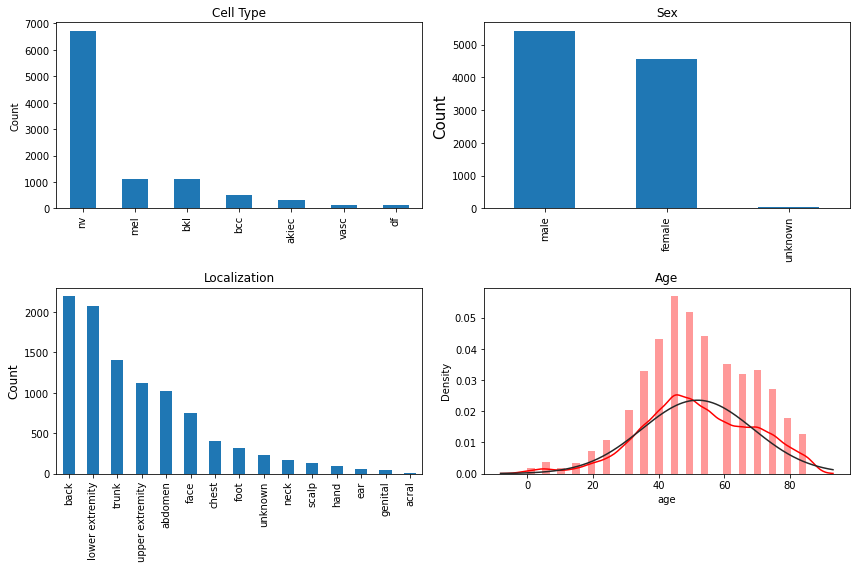

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [ ]:
# Distribution of data into various classes 
from sklearn.utils import resample
print("label Frequency")
print(skin_df['label'].value_counts())
print()
print("Class Frequency")
print(skin_df['dx'].value_counts())

label Frequency
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64

Class Frequency
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [ ]:
#Balance data.

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)


In [ ]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [ ]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())


5    500
3    500
1    500
6    500
4    500
2    500
0    500
Name: label, dtype: int64


In [ ]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/gdrive/MyDrive/IIITA Documents/M.Tech._2nd_SEM_Project_(mit2020068)/Datasets/HAM10000', '*', '*.jpg'))}

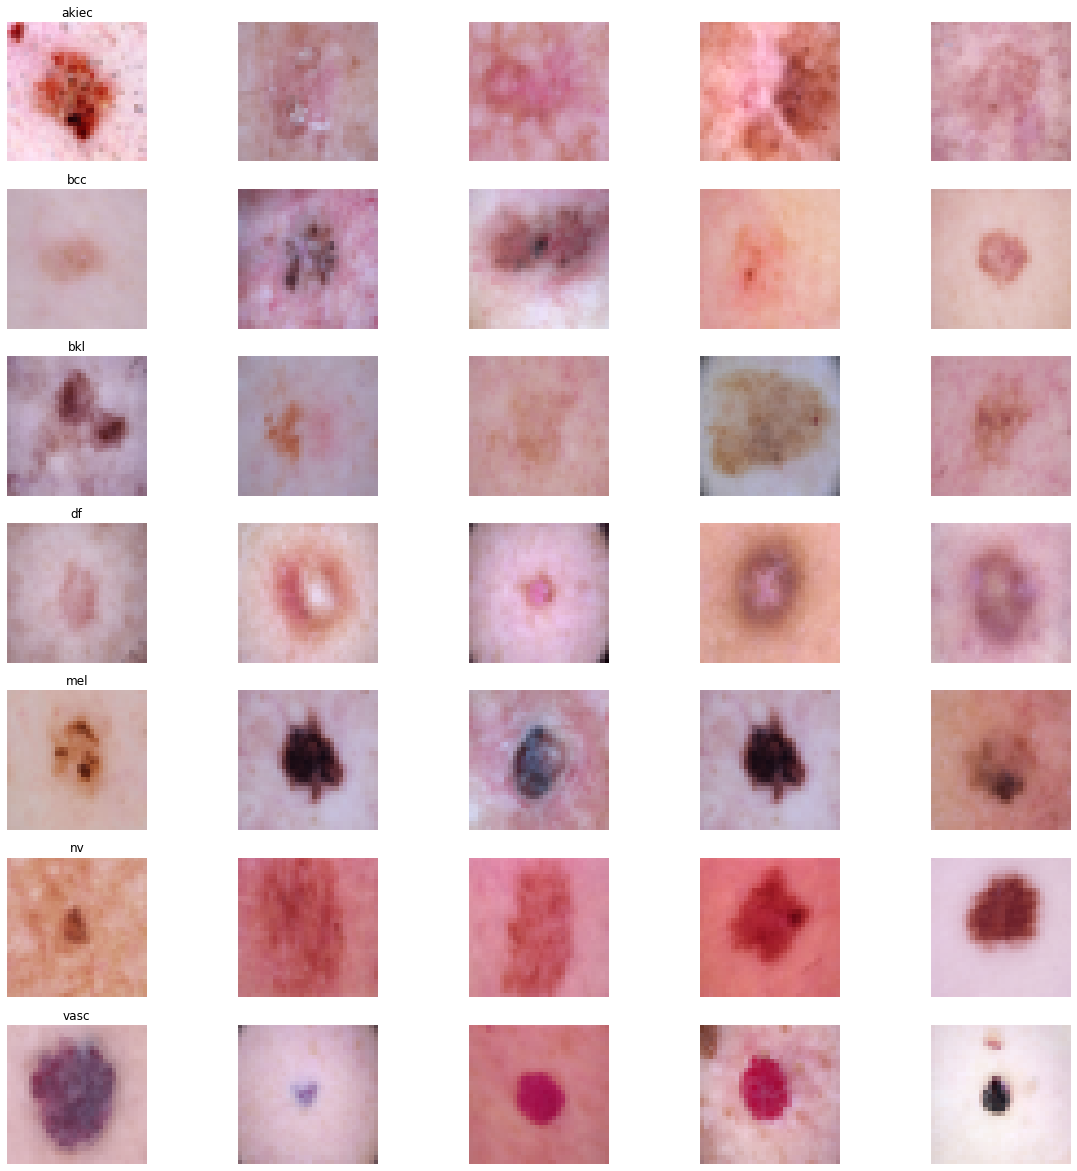

In [ ]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [ ]:
#Define the model.

num_classes = 7

model = Sequential()

# 256 filters(kernels) of shape 3*3 
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))

# Downsampling 
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#128 filters(kernels) of shape 3*3 
model.add(Conv2D(128, (3, 3),activation='relu'))

# Downsampling
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#64 filters(kernels) of shape 3*3 
model.add(Conv2D(64, (3, 3),activation='relu'))

# Downsampling 
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)         

In [ ]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


Epoch 1/50
165/165 - 24s - loss: 1.9050 - acc: 0.1966 - val_loss: 1.8301 - val_acc: 0.2789
Epoch 2/50
165/165 - 22s - loss: 1.6836 - acc: 0.3017 - val_loss: 1.5831 - val_acc: 0.3463
Epoch 3/50
165/165 - 23s - loss: 1.5180 - acc: 0.3653 - val_loss: 1.4504 - val_acc: 0.4057
Epoch 4/50
165/165 - 23s - loss: 1.4354 - acc: 0.4206 - val_loss: 1.4736 - val_acc: 0.3886
Epoch 5/50
165/165 - 23s - loss: 1.3845 - acc: 0.4571 - val_loss: 1.4044 - val_acc: 0.4046
Epoch 6/50
165/165 - 22s - loss: 1.3570 - acc: 0.4678 - val_loss: 1.3405 - val_acc: 0.4903
Epoch 7/50
165/165 - 23s - loss: 1.3067 - acc: 0.4811 - val_loss: 1.2736 - val_acc: 0.4731
Epoch 8/50
165/165 - 22s - loss: 1.2969 - acc: 0.4899 - val_loss: 1.3131 - val_acc: 0.4686
Epoch 9/50
165/165 - 22s - loss: 1.2467 - acc: 0.5154 - val_loss: 1.2566 - val_acc: 0.4903
Epoch 10/50
165/165 - 22s - loss: 1.2262 - acc: 0.4930 - val_loss: 1.2190 - val_acc: 0.5189
Epoch 11/50
165/165 - 22s - loss: 1.2103 - acc: 0.5280 - val_loss: 1.2120 - val_acc: 0.50

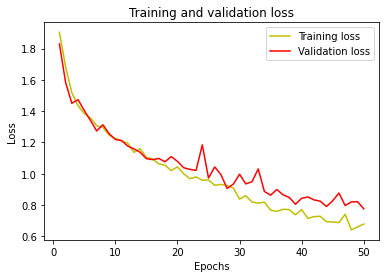

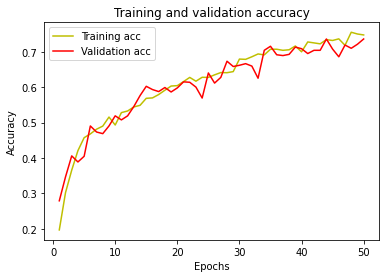

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

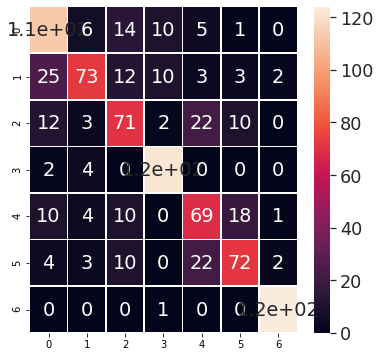

In [ ]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


Text(0, 0.5, 'Fraction of incorrect predictions')

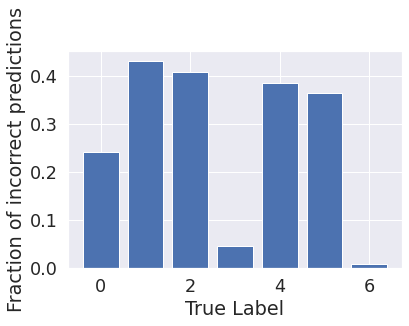

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')